In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]
!pip install Bio

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 1.2MB 5.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=e075a87eea0a22aaac57cc3696367c9f6d8737524328e3a51c40ef3d1a9cf366
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=77b2f1e9259ac3063e1f26257dfbaf857e9e1bb708ba471f1ab49207df330390
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
     |████████████████████████████████| 15.8MB 198kB/s 
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 112kB 37.9MB/s 
     |████████████████████████████████| 706kB 27.0MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-cp37-none-any.whl size=59430 sha256=9

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.plot

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Resources used to create code:
# https://github.com/aviolante/sas-python-work/blob/master/tSneExampleBlogPost.ipynb
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [ ]:
# getKmers() function adapted from Worksheet 3
def getKmers(sequence, sizek):
    return ' '.join([sequence[x:x+sizek].lower() for x in range(len(sequence) - sizek + 1)])

In [ ]:
# Load data
full_df = pd.read_csv('https://raw.githubusercontent.com/rcodipilly/ML-Taxonomy-classification-with-16S/master/sequences_cyano.csv')
full_df

,Unnamed: 0,sequence_name,domain,phylum,class,order,family,genus,species,location,ssu_length,contig_length,sequence
0,363497,>RS_GCF_002252665.1~NZ_NQKZ01000036.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp002252665,[location=4190..5670],[ssu_len=1480],[contig_len=6120],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
1,365444,>RS_GCF_900088535.1~NZ_LT578417.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=1568415..1569895],[ssu_len=1480],[contig_len=3021545],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
2,365445,>RS_GCF_900088535.1~NZ_LT578417.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=2822132..2823612],[ssu_len=1480],[contig_len=3021545],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
3,365446,>RS_GCF_900088535.1~NZ_LT578417.1-#3,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=1..1447],[ssu_len=1446],[contig_len=3021545],CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...
4,368404,>RS_GCF_000155635.1~NZ_DS990556.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp000155635,[location=2362934..2364414],[ssu_len=1480],[contig_len=2832412],GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,359903,>RS_GCF_000153045.1~NZ_CH724159.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp000153045,[location=574..2054],[ssu_len=1480],[contig_len=1792002],GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...
179,359904,>RS_GCF_000153045.1~NZ_CH724160.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp000153045,[location=1818..3298],[ssu_len=1480],[contig_len=1068361],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
180,368983,>RS_GCF_002252625.1~NZ_NQKW01000044.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp002252625,[location=4067..5547],[ssu_len=1480],[contig_len=6258],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
181,373396,>RS_GCF_001885215.1~NZ_CP018091.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp001885215,[location=800674..802154],[ssu_len=1480],[contig_len=2750634],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...


In [ ]:
# Number of sequences per genus
full_df.groupby('genus').genus.count().sort_values(ascending = False)

genus
Prochlorococcus_B    47
Synechococcus_C      39
Synechococcus_E      36
Prochlorococcus      22
Prochlorococcus_C    18
Cyanobium_A          11
WH-5701              10
Name: genus, dtype: int64

In [ ]:
# Subset dataframe
df = full_df[['genus',  'sequence']].rename(columns={'sequence': 'seq'})
df

,genus,seq
0,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
1,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
2,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
3,Cyanobium_A,CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...
4,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...
...,...,...
178,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...
179,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
180,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...
181,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...


In [ ]:
# Get kmer string for each sequence
df['kmer_string'] = df.seq.map(lambda x: getKmers(x, sizek=7))
df

,genus,seq,kmer_string
0,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...
1,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...
2,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...
3,Cyanobium_A,CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...,cggcgtg ggcgtgc gcgtgct cgtgctt gtgctta tgctta...
4,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...
...,...,...,...
178,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...
179,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...
180,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...
181,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...


In [ ]:
# Identify which sequences belong to each of the 2 broad clusters, as described in our paper
df['seq_type'] = df.seq.apply(lambda x: 'GAGGTGATCCA' in x or x.endswith('AAACTCTCCGTT'))
df

,genus,seq,kmer_string,seq_type
0,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
1,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
2,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
3,Cyanobium_A,CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...,cggcgtg ggcgtgc gcgtgct cgtgctt gtgctta tgctta...,False
4,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
...,...,...,...,...
178,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
179,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
180,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
181,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True


In [ ]:
# Subset sequences that belong in broad cluster #1
df1 = df[df.seq_type]
df1

,genus,seq,kmer_string,seq_type
0,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
1,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
2,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
7,Cyanobium_A,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
12,Prochlorococcus_B,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
...,...,...,...,...
172,Prochlorococcus,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
174,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
179,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True
180,WH-5701,GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,gaggtga aggtgat ggtgatc gtgatcc tgatcca gatcca...,True


In [ ]:
# Subset sequences that belong in broad cluster #2
df2 = df[df.seq_type == False]
df2

,genus,seq,kmer_string,seq_type
3,Cyanobium_A,CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...,cggcgtg ggcgtgc gcgtgct cgtgctt gtgctta tgctta...,False
4,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
5,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
6,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
8,Cyanobium_A,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
...,...,...,...,...
175,WH-5701,AGAGGATGATCAGCCACACTGGGACTGAGACACGGCCCAGACTCCT...,agaggat gaggatg aggatga ggatgat gatgatc atgatc...,False
176,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
177,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False
178,WH-5701,GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,ggagagt gagagtt agagttt gagtttg agtttga gtttga...,False


In [ ]:
# Create the Bag of Words model
cv = CountVectorizer()
X = cv.fit_transform(df['kmer_string'].to_list()).toarray()
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [ ]:
# Set style of scatterplot
sns.set_context('notebook', font_scale=1.1)
sns.set_style('ticks')

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


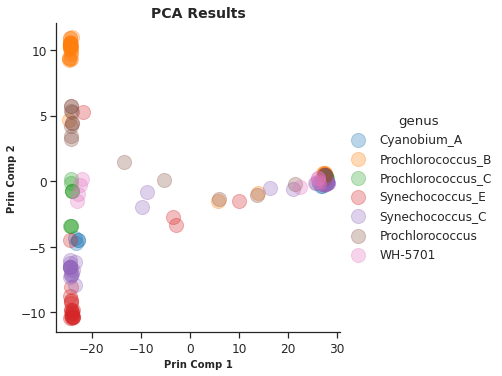

In [ ]:
# PCA plot
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

pca_df = pd.DataFrame(data = pca_results, columns = ['pca_1', 'pca_2'])
pca_df = pd.concat([pca_df, df[['genus']]], axis = 1)

sns.lmplot(x='pca_1',
           y='pca_2',
           data=pca_df,
           fit_reg=False,
           legend=True,
           size=5,
           hue='genus',
           scatter_kws={"s":200, "alpha":0.3})

plt.title('PCA Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


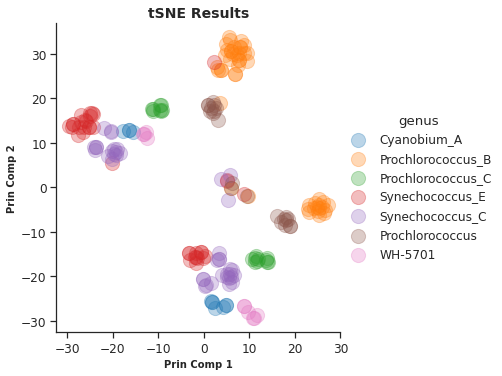

In [ ]:
# tSNE
tsne = TSNE(perplexity=14, n_components=2)
tsne_results = tsne.fit_transform(X)

tsne_df = pd.DataFrame(data = tsne_results, columns = ['tsne_1', 'tsne_2'])
tsne_df = pd.concat([tsne_df, df[['genus']]], axis = 1)

sns.lmplot(x='tsne_1',
           y='tsne_2',
           data=tsne_df,
           fit_reg=False,
           legend=True,
           size=5,
           hue='genus',
           scatter_kws={"s":200, "alpha":0.3})

plt.title('tSNE Results', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

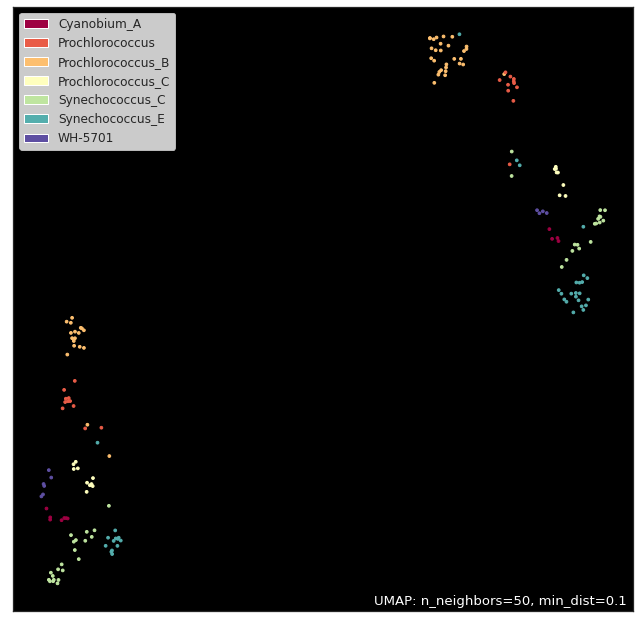

In [ ]:
# UMAP
trans = umap.UMAP(n_neighbors=50, random_state=42).fit(X)
umap.plot.points(trans, labels=df['genus'].values, theme = 'inferno')

In [ ]:
# Create labels for interactive UMAP below
labels_df = full_df
labels_df['seq_type'] = labels_df.sequence.apply(lambda x: 'GAGGTGATCCA' in x or x.endswith('AAACTCTCCGTT'))
labels_df = labels_df[['seq_type', 'sequence_name']]

labels_df

,seq_type,sequence_name
0,True,>RS_GCF_002252665.1~NZ_NQKZ01000036.1
1,True,>RS_GCF_900088535.1~NZ_LT578417.1
2,True,>RS_GCF_900088535.1~NZ_LT578417.1-#2
3,False,>RS_GCF_900088535.1~NZ_LT578417.1-#3
4,False,>RS_GCF_000155635.1~NZ_DS990556.1
...,...,...
178,False,>RS_GCF_000153045.1~NZ_CH724159.1
179,True,>RS_GCF_000153045.1~NZ_CH724160.1-#2
180,True,>RS_GCF_002252625.1~NZ_NQKW01000044.1
181,True,>RS_GCF_001885215.1~NZ_CP018091.1-#2


In [ ]:
# Interactive UMAP, separated by the 2 broad clusters
umap.plot.output_notebook()
p = umap.plot.interactive(trans, labels=labels_df['seq_type'].values, theme = 'inferno', hover_data=labels_df, point_size=5)
umap.plot.show(p)

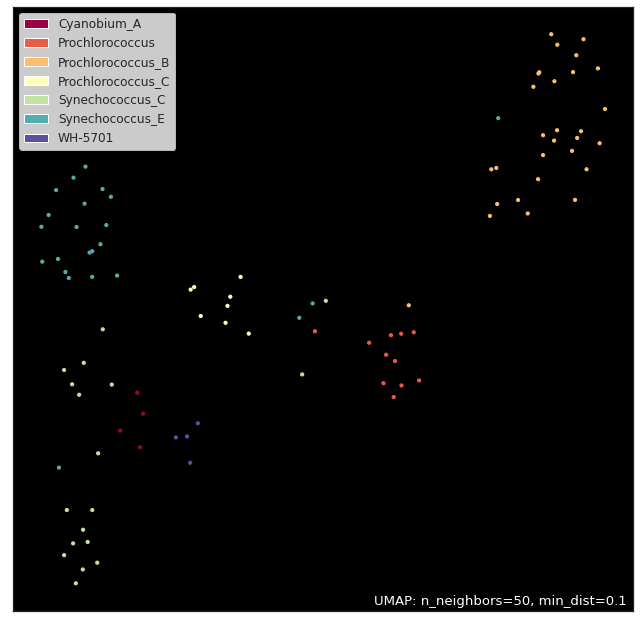

In [ ]:
# UMAP of just the purple cluster (df1)
cv = CountVectorizer()
X1 = cv.fit_transform(df1['kmer_string'].to_list()).toarray()

trans = umap.UMAP(n_neighbors=50, random_state=42).fit(X1)
umap.plot.points(trans, labels=df1['genus'].values, theme = 'inferno')

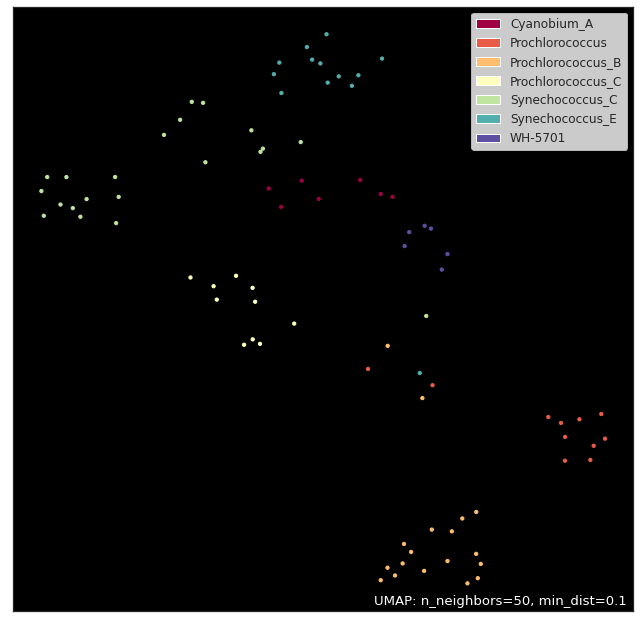

In [ ]:
# UMAP of just the red cluster (df2)
cv = CountVectorizer()
X2 = cv.fit_transform(df2['kmer_string'].to_list()).toarray()

trans = umap.UMAP(n_neighbors=50, random_state=42).fit(X2)
umap.plot.points(trans, labels=df2['genus'].values, theme = 'inferno')

In [ ]:
# Naive Bayes Classification Model adapted from Worksheet 6
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    df.iloc[:, 0].values, 
                                                    test_size = 0.20, 
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(146, 5934)
(37, 5934)


In [ ]:
# Results using the Native Bayes Classifier 
classifier = MultinomialNB(alpha=0.1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print("Confusion matrix\n")

with pd.option_context('display.max_columns', None):
  print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))

def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("\naccuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted          Cyanobium_A  Prochlorococcus  Prochlorococcus_B  \
Actual                                                               
Cyanobium_A                  1                0                  0   
Prochlorococcus              0                3                  0   
Prochlorococcus_B            0                1                 12   
Prochlorococcus_C            0                0                  0   
Synechococcus_C              0                0                  0   
Synechococcus_E              0                0                  0   
WH-5701                      0                0                  0   

Predicted          Prochlorococcus_C  Synechococcus_C  Synechococcus_E  \
Actual                                                                   
Cyanobium_A                        0                0                0   
Prochlorococcus                    0                0                0   
Prochlorococcus_B                  0                0  

In [ ]:
# One-hot encoding and deep-learning model adpated from Worksheet 8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re

sequence_url = 'https://raw.githubusercontent.com/rcodipilly/ML-Taxonomy-classification-with-16S/master/cyano_aligned.fasta'

sequence_data = re.findall('(>.+)\n([-ACGTN\n]+)', requests.get(sequence_url).text)
sequences = [s[1].replace('\n', '').replace('-', 'N').strip() for s in sequence_data]

print(len(sequences))
sequences[:5]

183


['NNNNGAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACTTCACCCCAGTCATCAGCCCCACCTTCGGCATCCTCCTCCCTTGCGGGTTGGAGTAACGACTTCGGGCGTGGCCAACTTCCATGGTGTGACGGGCGGTGTGTACAAGGCCCGGGAACGTATTCACCGCAGTNATGCTGACCTGCGATTACTAGCGATTCCTCCTTCACGTAGGCGAGTTGCAGCCTACGATCTGAACTGAGCCACGGTTTATGGGATTTGCTAGCTCTCGCGAGTTTGCTGCCCTTTGTCCGTAGCATTGTAGTACGTGTGTAGCCCAGGATGTAAGGGGCATGATGACTTGACGTCATCCACACCTTCCTCCGGTTTATNNCACCGGCGGTCTCTCTAGAGTGCCCANNACTAAATGCTGGCAACTAAAGACGTGGGTTGCGCTCGTTGCGGGACTTAACCCAACATCTCACGACACGAGCTGACNNNNNNNGACAGCCATGCACCACCTGTCACTGCGTTCCCGAAGNNNNNNNNNNNNNGCACTCCCAAGTTTCCAAGGGATTCGCAGGATGTCAAACCCTGGTAAGGTTCTTCGCGTTGCATCGAATTAAACCACATACTCCACCGCTTGTGCGGGNCCCCCGTCAATTCCTTTGAGTTTCACACTTGCGTGCGTACTCCCCAGGCGGAACACTTAACGCGTTGGCTACGACACCGAGGGGGTCGNNNNNNNNNNNANTTCCCCCGACACCTAGTGTTCATCGTTTACGGCCAGGACTACAGGGGTATCTAATCCCTTTCGCTCCCCTGGCTTTCGNNNNNNNNNTCCATGAGCGTCANGTTATGGCCCAGCAGAGCGCCTTCGCCACTGGTGTTCTTCCCGATATCNTACGCATTTCACCGCTACACCGGGAATTCCCTCTGCCCCTACCACACTCTAGTCTTGTAGTTTCCATTGCTGAAATGGAGTTAAGCTCCACGCTTTAACAACAGACN

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 NNNNGAGGTG ... CTCTCCGTTN
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [ ]:
sequence_names = [s[0].strip() for s in sequence_data]

seq_labels_df = pd.DataFrame(data = {'seq_names': sequence_names}).join(full_df)
seq_labels_df

,seq_names,Unnamed: 0,sequence_name,domain,phylum,class,order,family,genus,species,location,ssu_length,contig_length,sequence,seq_type
0,>RS_GCF_002252665.1~NZ_NQKZ01000036.1,363497,>RS_GCF_002252665.1~NZ_NQKZ01000036.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp002252665,[location=4190..5670],[ssu_len=1480],[contig_len=6120],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True
1,>RS_GCF_900088535.1~NZ_LT578417.1,365444,>RS_GCF_900088535.1~NZ_LT578417.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=1568415..1569895],[ssu_len=1480],[contig_len=3021545],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True
2,>RS_GCF_900088535.1~NZ_LT578417.1-#2,365445,>RS_GCF_900088535.1~NZ_LT578417.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=2822132..2823612],[ssu_len=1480],[contig_len=3021545],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True
3,>RS_GCF_900088535.1~NZ_LT578417.1-#3,365446,>RS_GCF_900088535.1~NZ_LT578417.1-#3,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp900088535,[location=1..1447],[ssu_len=1446],[contig_len=3021545],CGGCGTGCTTAACACATGCAAGTCGAACGCACCTTCGGGTGAGTGG...,False
4,>RS_GCF_000155635.1~NZ_DS990556.1,368404,>RS_GCF_000155635.1~NZ_DS990556.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,Cyanobium_A,Cyanobium_A sp000155635,[location=2362934..2364414],[ssu_len=1480],[contig_len=2832412],GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,>RS_GCF_000153045.1~NZ_CH724159.1,359903,>RS_GCF_000153045.1~NZ_CH724159.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp000153045,[location=574..2054],[ssu_len=1480],[contig_len=1792002],GGAGAGTTTGATCCTGGCTCAGGATGAACGCTGGCGGCGTGCTTAA...,False
179,>RS_GCF_000153045.1~NZ_CH724160.1-#2,359904,>RS_GCF_000153045.1~NZ_CH724160.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp000153045,[location=1818..3298],[ssu_len=1480],[contig_len=1068361],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True
180,>RS_GCF_002252625.1~NZ_NQKW01000044.1,368983,>RS_GCF_002252625.1~NZ_NQKW01000044.1,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp002252625,[location=4067..5547],[ssu_len=1480],[contig_len=6258],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True
181,>RS_GCF_001885215.1~NZ_CP018091.1-#2,373396,>RS_GCF_001885215.1~NZ_CP018091.1-#2,Bacteria,Cyanobacteria,Cyanobacteriia,PCC-6307,Cyanobiaceae,WH-5701,WH-5701 sp001885215,[location=800674..802154],[ssu_len=1480],[contig_len=2750634],GAGGTGATCCAGCCGCACCTTCCGGTACGGCTACCTTGTTACGACT...,True


In [ ]:
(sequence_names == full_df.sequence_name).unique()

array([ True])

In [ ]:
(seq_labels_df.genus == full_df.genus).unique()

array([ True])

In [ ]:
labels = list(full_df.genus)

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['Cyanobium_A' 'Cyanobium_A' 'Cyanobium_A' ... 'WH-5701' 'WH-5701'
  'WH-5701']]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

In [ ]:
train_features.shape

(137, 1634, 5)

In [ ]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

print('build_model input_shape:',train_features.shape[1], ' by ' , 5)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 5)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

build_model input_shape: 1634  by  5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1623, 32)          1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 405, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 12960)             0         
_________________________________________________________________
dense (Dense)                (None, 20)                259220    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 147       
Total params: 261,319
Trainable params: 261,319
Non-trainable params: 0
_________________________________________________________________


In [ ]:
predicted_labels = model.predict(np.stack(test_features))
predicted_labels

with pd.option_context('display.max_columns', None):
  print(pd.crosstab(pd.Series(np.argmax(test_labels, axis=1), name='Actual'),
                    pd.Series(np.argmax(predicted_labels, axis=1), name='Predicted')))

Predicted  2  3   5
Actual             
0          1  0   0
1          3  0   0
2          4  0  12
3          4  0   3
4          3  2   6
5          3  1   2
6          0  1   1


In [ ]:
# Confusion matrix for one-hot encoding/deep-learning model
df = pd.crosstab(pd.Series(np.argmax(test_labels, axis=1), name='Actual'),
                 pd.Series(np.argmax(predicted_labels, axis=1), name='Predicted'))

df.reindex(index=df.index, columns=range(7), fill_value=0)

Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,0,0,1,0,0,0,0
1,0,0,3,0,0,0,0
2,0,0,4,0,0,12,0
3,0,0,4,0,0,3,0
4,0,0,3,2,0,6,0
5,0,0,3,1,0,2,0
6,0,0,0,1,0,1,0
